In [1]:
import os
import sys
sys.path.append('/home/souravc83/trading_ideas')
%load_ext autoreload
%autoreload 2

In [2]:
from src.stock import Stock, Holding, Universe
from src.backtest import BackTest
from src.linreg_strategy import LinRegStrategy
from src.factor import (
    LinRegFactor, 
    linreg_stock, 
    MovingAverageFactor,
    PercReturnFactor
)
from src.read_write import ReadData, check_valid_symbol

/home/souravc83/.local/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from typing import List
import copy
from math import floor

In [4]:
# read the file and filter
offline_filename = '/home/souravc83/trading_ideas/src/data/offline_price_data.csv'
all_df = pd.read_csv(offline_filename)
all_df['daily_change'] = (all_df['High'] - all_df['Low'])/all_df['High']
all_df['date'] = pd.to_datetime(all_df['date'])
all_df = all_df.sort_values(by=['symbol', 'date'])
all_df.head()

,Open,High,Low,Close,Adj Close,Volume,symbol,date,daily_change
115788,41.180000,41.310001,40.369999,40.560001,38.553932,1529200.0,A,2015-01-02,0.022755
115789,40.320000,40.459999,39.700001,39.799999,37.831524,2041800.0,A,2015-01-05,0.018784
115790,39.810001,40.020000,39.020000,39.180000,37.242188,2080600.0,A,2015-01-06,0.024988
115791,39.520000,39.810001,39.290001,39.700001,37.736473,3359700.0,A,2015-01-07,0.013062
115792,40.240002,40.980000,40.180000,40.889999,38.867619,2116300.0,A,2015-01-08,0.019522


In [5]:
def get_symbol_date_df(sector_etf: str = 'VDC',
                       start_date: str = '2019-03-01',
                       end_date: str = '2020-03-01'):
    
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

    sector_df = all_df.query(f"symbol=='{sector_etf}'")
    sector_df = sector_df[(sector_df.date > start_date_dt) & 
                      (sector_df.date < end_date_dt)]
    #sector_df.head()
    sector_df = sector_df[['date', 'Close']]
    sector_df['Close'] = sector_df['Close']/sector_df['Close'].values[0]
    return sector_df

def compare_to_voo(symbol: str = 'VDC',
                   start_date: str = '2019-03-01',
                   end_date: str = '2020-03-01',
                   visualize=True):
    voo_df = get_symbol_date_df('VOO', start_date, end_date)
    voo_df = voo_df[['date', 'Close']]
    voo_df.columns = ['date', 'voo_close']
    
    sector_df = get_symbol_date_df(symbol, start_date, end_date)
    sector_df = sector_df[['date', 'Close']]
    sector_df.columns = ['date', 'sector_close']
    
    
    comb_df = voo_df.merge(sector_df, on='date')
    
    comb_df['ratio'] = comb_df['sector_close']/comb_df['voo_close']
    
    #print(voo_df.head())
    #print(sector_df.head())
    #print(comb_df.head())
    
    if visualize:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.plot(comb_df.date, comb_df.ratio, 'r--')
        ax.xaxis.set_tick_params(rotation=45)
    
    return comb_df
    
    
    

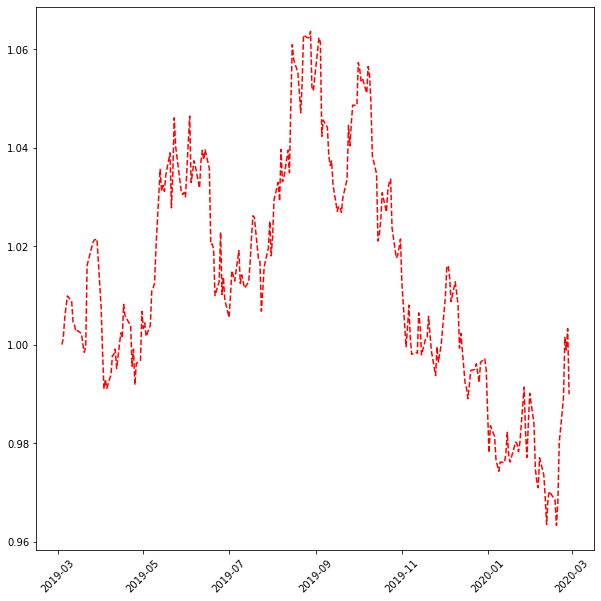

In [6]:
consumer_df = compare_to_voo(symbol='VDC')

In [7]:
# get all the sector ETFs and plot
sector_etf_dict = {
    'consumer_staples': 'VDC',
    'consumer_disc': 'VCR',
    'communication': 'VOX',
    'energy': 'VDE',
    'financials': 'VFH',
    'healthcare': 'VHT',
    'industrials': 'VIS',
    'information_tech': 'VGT',
    'materials': 'VAW',
    'real_estate': 'VNQ',
    'utilities': 'VPU'
    
}

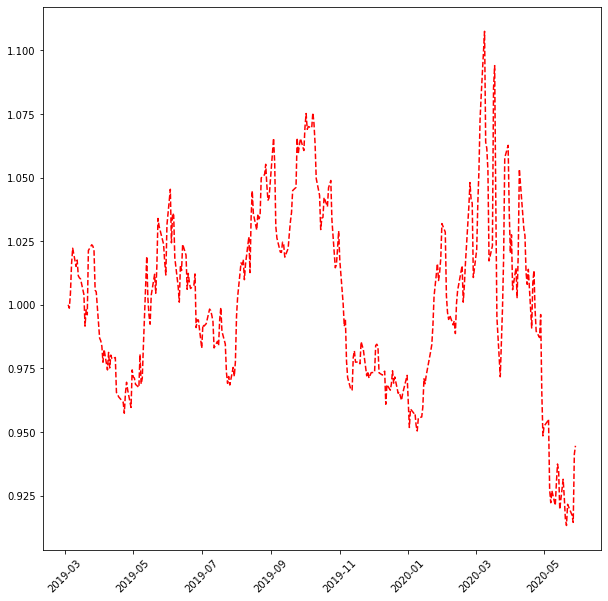

In [8]:
# healthcare: doing well after march, 
# information_tech: doing well before/after march
# consumer disc: doing well after march
# 

sector = 'utilities'
sector_symbol = sector_etf_dict[sector]
start_date='2019-03-01'
end_date = '2020-06-01'
comb_df = compare_to_voo(symbol=sector_symbol, 
                         start_date=start_date, 
                         end_date=end_date)

In [9]:
# small program to buy and sell

def my_strategy(stock_dict):
    perc_dict = {k:(1. if k=='VGT' else 0.) for k in stock_dict.keys()}
    return perc_dict

def voo_strategy(stock_dict):
    perc_dict = {k:(1. if k=='VOO' else 0.) for k in stock_dict.keys()}
    return perc_dict

def lookup_price(symbol: str, date: str):
    sector_df = all_df.query(f"symbol=='{symbol}'")
    date_dt = datetime.strptime(date, '%Y-%m-%d')
    
    sector_df = sector_df[sector_df.date == date_dt]
    
    return sector_df['Close'].values[0]

def exec_buy(date, stock_dict, cash, strategy):
    perc_dict = strategy(stock_dict)

    cash_spent = 0.
    
    buy_dict = {}
    
    for k, v in perc_dict.items():
        price = lookup_price(k, date)
        cash_alloc = cash*v
        num_shares = floor(cash_alloc/price)
  
        buy_dict[k] = num_shares
        cash_spent += num_shares*price
    
    
    cash_in_hand = cash - cash_spent
    assert(cash_in_hand >= 0.)
    
    return buy_dict, cash_in_hand

def exec_sell(date, stock_dict, cash):
    sell_dict = {k:0. for k in stock_dict.keys()}
    
    total_cash = cash
    for k,v in stock_dict.items():
        price = lookup_price(k, date)
        total_cash += (price*v)
    
    return sell_dict, total_cash
    

def simulate_buy_sell(dates: List[str], start_cash: float, 
                      all_stocks: List[str]):
    cash_voo = start_cash
    cash_strat = start_cash
    
    
    strat_earnings = [start_cash]
    voo_earnings = [start_cash]
    
    this_strat_dict = {x:0 for x in all_stocks}
    voo_dict = {x: 0 for x in all_stocks}
    
    # first time buy
    this_strat_dict,cash_strat = exec_buy(
            dates[0],this_strat_dict, 
            cash_strat, my_strategy)
    
        
    voo_dict, cash_voo = exec_buy(
        dates[0], voo_dict, 
        cash_voo, voo_strategy)
    
    
    for date_str in dates[1:]:
        print(date_str)
        # sell
        this_strat_dict,cash_strat = exec_sell(
            date_str, this_strat_dict, cash_strat
        )
        
        voo_dict, cash_voo = exec_sell(
            date_str, voo_dict, cash_voo)
        
        strat_earnings.append(cash_strat)
        voo_earnings.append(cash_voo)
        
        # buy
        this_strat_dict,cash_strat = exec_buy(
            date_str,this_strat_dict, 
            cash_strat, my_strategy)
        
        
        voo_dict, cash_voo = exec_buy(
            date_str, voo_dict, 
            cash_voo, voo_strategy)
        
       
    
    dates_dt = [datetime.strptime(x, '%Y-%m-%d') for x in dates]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(dates_dt, strat_earnings, 'r--', label='Strategy')
    ax.plot(dates_dt, voo_earnings, 'b--', label='VOO')
    ax.legend()
        
    ax.xaxis.set_tick_params(rotation=45)
    
    
        
    

2019-04-01
2019-05-01
2019-06-03
2019-07-01
2019-08-01
2019-09-03
2019-10-01
2019-11-01
2019-12-02


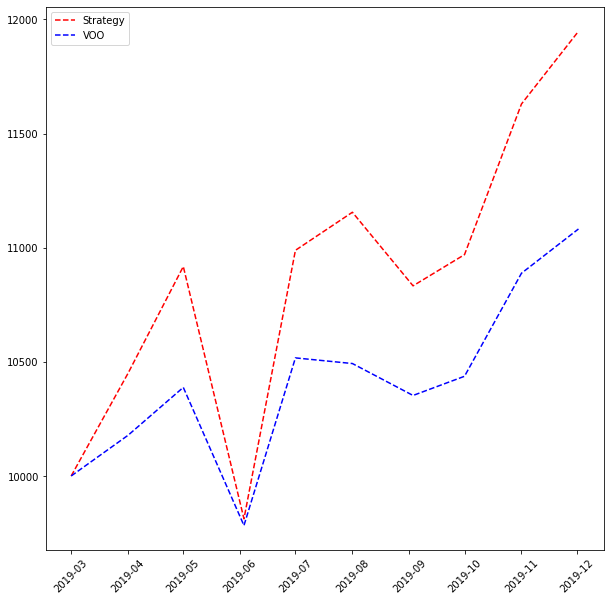

In [10]:
stock_list = ['VDC', 'VCR', 'VOO', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU']
date_list = ['2019-03-01', '2019-04-01', '2019-05-01', '2019-06-03', '2019-07-01',
             '2019-08-01', '2019-09-03', '2019-10-01', '2019-11-01', '2019-12-02']
start_cash = 10e3
simulate_buy_sell(date_list, start_cash, stock_list)
#sector_etf_dict.values()

In [71]:
this_strat_dict = {x:0 for x in stock_list}
exec_buy(
            '2019-03-01',this_strat_dict, 
            10e3, my_strategy)

TypeError: exec_buy() takes 3 positional arguments but 4 were given